In [2]:
import numpy as np
import matplotlib.patches as patches
from tqdm import tqdm
import matplotlib.pyplot as plt

x_train = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy')
y_train = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy')
x_test = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy')
y_test = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy')
x_val = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/x_val.npy')
y_val = np.load('/kaggle/input/cifar10-hw3/cifar_hw3/y_val.npy')

print("Caricamento completato con successo!")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

Caricamento completato con successo!
x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)


Cleaning Images: 100%|██████████| 40000/40000 [19:01<00:00, 35.05it/s]
/tmp/ipykernel_35/1309725445.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Original: {class_names[int(y[idx])]}")
/tmp/ipykernel_35/1309725445.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Cleaned: {class_names[int(y[idx])]}")


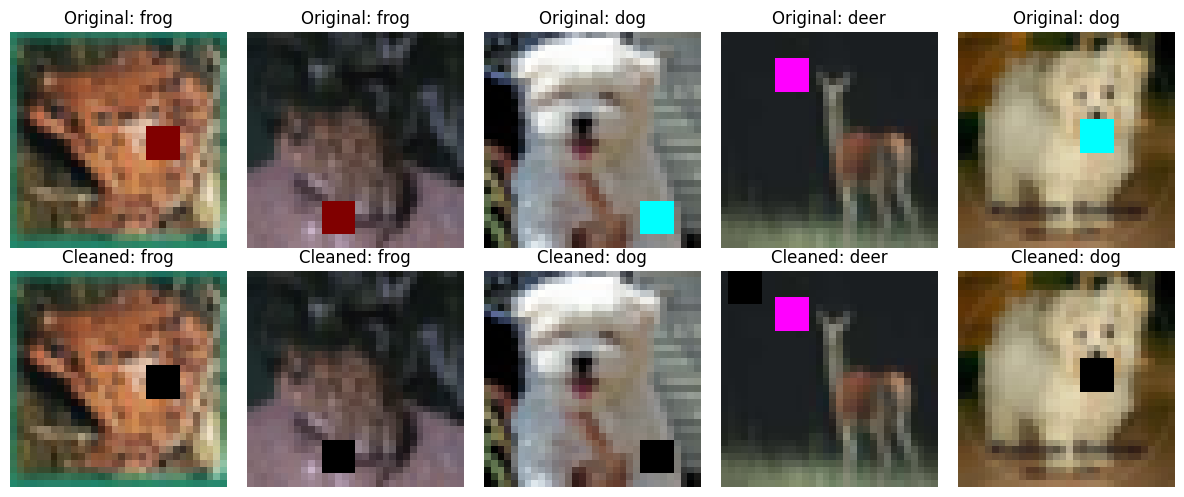

In [3]:

def remove_uniform_square(image, square_size=5, std_threshold=15):
    h, w, c = image.shape
    min_std = float('inf')
    best_coords = (0, 0)

    # Cerco la patch con deviazione standard minima (più uniforme)
    for i in range(h - square_size + 1):
        for j in range(w - square_size + 1):
            patch = image[i:i+square_size, j:j+square_size, :]
            patch_std = np.std(patch, axis=(0,1))
            mean_std = np.mean(patch_std)
            if mean_std < min_std:
                min_std = mean_std
                best_coords = (i, j)

    # Se la deviazione standard è abbastanza bassa, sostituisco la patch
    if min_std < std_threshold:
        i, j = best_coords
        image[i:i+square_size, j:j+square_size, :] = 0

    return image
    
def clean_dataset(images, square_size=5, std_threshold=15):
    cleaned_images = np.empty_like(images)
    for idx in tqdm(range(images.shape[0]), desc="Cleaning Images"):
        cleaned_images[idx] = remove_uniform_square(images[idx].copy(), square_size, std_threshold)
    return cleaned_images

def plot_examples(orig, cleaned, y, class_names, num_samples=5):
    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(orig))
        plt.subplot(2, num_samples, i+1)
        plt.imshow(orig[idx])
        plt.title(f"Original: {class_names[int(y[idx])]}")
        plt.axis('off')
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(cleaned[idx])
        plt.title(f"Cleaned: {class_names[int(y[idx])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

x_train_black = clean_dataset(x_train, square_size=5)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
# Visualizzo esempi a confronto
plot_examples(x_train, x_train_black, y_train, class_names)



In [4]:
from sklearn.model_selection import train_test_split
from itertools import product
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

# Ignora i warning globalmente
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Flatten immagini pulite
x_train_ready = x_train_black.reshape((x_train_black.shape[0], -1))
x_val_ready   = x_val.reshape((x_val.shape[0], -1))
x_test_ready  = x_test.reshape((x_test.shape[0], -1))

# Normalize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_ready)
x_val_scaled   = scaler.transform(x_val_ready)
x_test_scaled  = scaler.transform(x_test_ready)

param_grid = {
    'hidden_layer_sizes': [(128, 128), (256, 128)],
    'alpha': [1e-4, 1e-5],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.0005],
    'max_iter': [100]
}


patience = 5
tolerance = 1e-4
best_val_acc_overall = 0.0  
best_model = None
best_params = {}
best_train_accs = []
best_val_accs = []

# Estrai un 20% casuale e stratificato del training set originale
#x_train_sample, _, y_train_sample, _ = train_test_split(
#   x_train_scaled, y_train, test_size=0.5, stratify=y_train, random_state=42
#)

# Ora usa x_train_sample e y_train_sample nel ciclo di training
for hls, alpha, activation, solver, lr_init, max_iter in product(
        param_grid['hidden_layer_sizes'],
        param_grid['alpha'],
        param_grid['activation'],
        param_grid['solver'],
        param_grid['learning_rate_init'],
        param_grid['max_iter']):

    print(f"\n--- Training: hls={hls}, alpha={alpha}, activation={activation}, solver={solver}, lr={lr_init}, max_iter={max_iter} ---")

    mlp = MLPClassifier(
        hidden_layer_sizes=hls,
        alpha=alpha,
        activation=activation,
        solver=solver,
        learning_rate_init=lr_init,
        max_iter=1,
        warm_start=True,
        random_state=42,
        verbose=False
    )

    best_val_accuracy = 0.0
    epochs_without_improvement = 0
    train_accuracies = []
    val_accuracies = []
    best_coefs = None
    best_intercepts = None

    for epoch in range(max_iter):
        mlp.fit(x_train_scaled, y_train)
        train_preds = mlp.predict(x_train_scaled)
        val_preds = mlp.predict(x_val_scaled)

        train_acc = accuracy_score(y_train, train_preds)
        val_acc = accuracy_score(y_val, val_preds)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoca {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        if val_acc >= best_val_accuracy + tolerance:
            best_val_accuracy = val_acc
            epochs_without_improvement = 0
            best_coefs = [w.copy() for w in mlp.coefs_]
            best_intercepts = [b.copy() for b in mlp.intercepts_]
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping alla epoca {epoch+1}")
            break

    if best_val_accuracy > best_val_acc_overall:
        best_val_acc_overall = best_val_accuracy
        best_model = mlp
        best_model.coefs_ = best_coefs
        best_model.intercepts_ = best_intercepts
        best_params = {
            'hidden_layer_sizes': hls,
            'alpha': alpha,
            'activation': activation,
            'solver': solver,
            'learning_rate_init': lr_init,
            'max_iter': max_iter
        }
        best_train_accs = train_accuracies
        best_val_accs = val_accuracies



--- Training: hls=(128, 128), alpha=0.0001, activation=relu, solver=adam, lr=0.001, max_iter=100 ---
Epoca 1: Train Acc = 0.4568, Val Acc = 0.4369
Epoca 2: Train Acc = 0.4989, Val Acc = 0.4555
Epoca 3: Train Acc = 0.5327, Val Acc = 0.4693
Epoca 4: Train Acc = 0.5585, Val Acc = 0.4777
Epoca 5: Train Acc = 0.5746, Val Acc = 0.4759
Epoca 6: Train Acc = 0.5959, Val Acc = 0.4794
Epoca 7: Train Acc = 0.6069, Val Acc = 0.4754
Epoca 8: Train Acc = 0.6221, Val Acc = 0.4771
Epoca 9: Train Acc = 0.6325, Val Acc = 0.4755
Epoca 10: Train Acc = 0.6446, Val Acc = 0.4787
Epoca 11: Train Acc = 0.6530, Val Acc = 0.4722
Early stopping alla epoca 11

--- Training: hls=(128, 128), alpha=0.0001, activation=relu, solver=adam, lr=0.0005, max_iter=100 ---
Epoca 1: Train Acc = 0.4549, Val Acc = 0.4300
Epoca 2: Train Acc = 0.5088, Val Acc = 0.4630
Epoca 3: Train Acc = 0.5412, Val Acc = 0.4764
Epoca 4: Train Acc = 0.5651, Val Acc = 0.4813
Epoca 5: Train Acc = 0.5830, Val Acc = 0.4836
Epoca 6: Train Acc = 0.6000,


--- Risultati finali ---
Migliori parametri: {'hidden_layer_sizes': (128, 128), 'alpha': 0.0001, 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.0005, 'max_iter': 100}
Migliore accuratezza di validazione: 0.4855
Accuracy finale sul test set: 0.4860

Classification Report:
              precision    recall  f1-score   support

    airplane       0.55      0.58      0.56      1000
  automobile       0.57      0.57      0.57      1000
        bird       0.41      0.38      0.39      1000
         cat       0.33      0.21      0.26      1000
        deer       0.44      0.36      0.39      1000
         dog       0.37      0.46      0.41      1000
        frog       0.47      0.59      0.52      1000
       horse       0.59      0.52      0.55      1000
        ship       0.56      0.69      0.62      1000
       truck       0.54      0.51      0.52      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weight

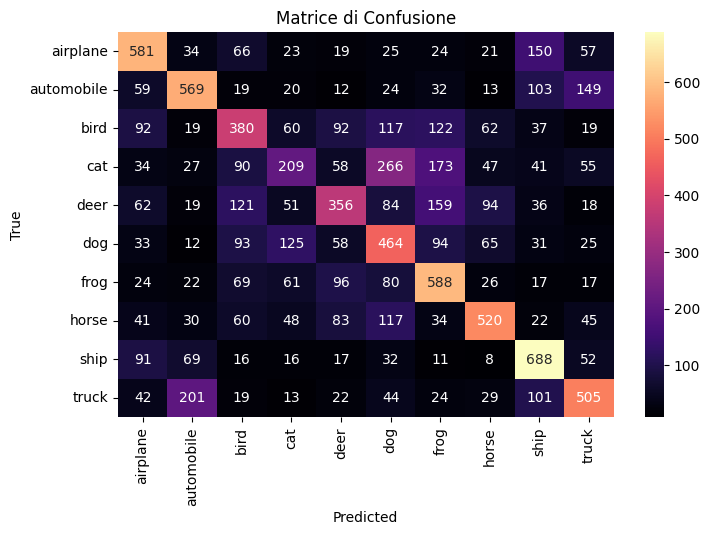

In [5]:

print("\n--- Risultati finali ---")
print(f"Migliori parametri: {best_params}")
print(f"Migliore accuratezza di validazione: {best_val_acc_overall:.4f}")

# Predict sul test set con il modello best
test_preds = best_model.predict(x_test_scaled)
test_acc = accuracy_score(y_test, test_preds)
print(f"Accuracy finale sul test set: {test_acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, test_preds, target_names=class_names))

# Matrice di confusione
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice di Confusione')
plt.show()


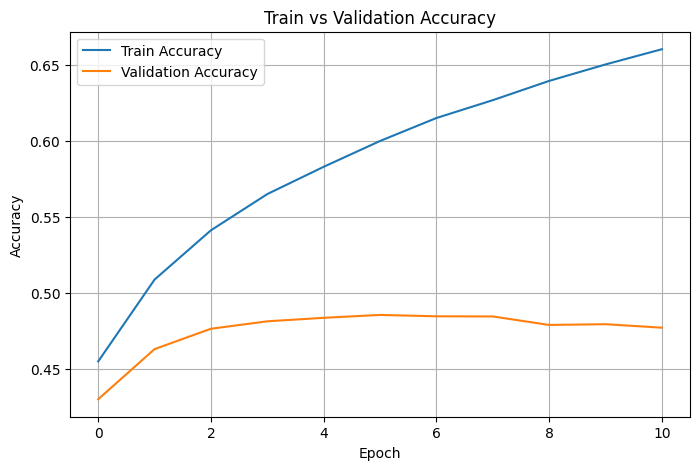

In [6]:
plt.figure(figsize=(8,5))
plt.plot(best_train_accs, label='Train Accuracy')
plt.plot(best_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
